# Install the required libraries

We will continue our use of NTLK from the basic sentiment analysis notebook, however we distance ourselves from the use of the VADER sentiment analysis tool. We will be using the TfidfVectorizer from the sklearn library to convert our text data into a numerical format that can be used by our neural network. We will also be using the LSTM layer from the tensorflow library to create our neural network.

In [1]:
import json
import pandas as pd
import numpy as np
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Load and preprocess the data

After loading the data from the JSON file, we will combine the post titles and comments into a single text column. We will then preprocess the text data by removing special characters, converting the text to lowercase, tokenizing the text, removing stopwords, and lemmatizing the tokens. We will store the preprocessed text in a new column called 'cleaned_text'.

In [2]:
# Craft file path to the JSON file in parent directory
from os import path
json_file_path = path.join(path.dirname(path.abspath('')), 'wallstreetbets_posts.json')

# Load data from JSON file
with open(json_file_path) as json_file:
    data = json.load(json_file)

# Convert the loaded data into a pandas DataFrame
df = pd.DataFrame(data)

# download the stopwords
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Preprocess the text data
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    if isinstance(text, float):  # Check if the text is a float (NaN)
        return ''
    
    # Remove special characters and convert to lowercase
    text = re.sub(r'[^a-zA-Z0-9\s]', '', str(text).lower())
    
    # Tokenize the text
    tokens = nltk.word_tokenize(text)
    
    # Remove stopwords and lemmatize tokens
    cleaned_tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
    
    return ' '.join(cleaned_tokens)

# Preprocess the title and text columns
df['cleaned_title'] = df['title'].apply(preprocess_text)
df['cleaned_text'] = df['text'].apply(preprocess_text)

# Preprocess the comments data
def preprocess_comments(comments):
    if isinstance(comments, float):  # Check if comments is a float (NaN)
        return []
    
    cleaned_comments = []
    for comment in comments:
        cleaned_comment = preprocess_text(comment['body'])
        cleaned_comments.append(cleaned_comment)
    
    return cleaned_comments

df['cleaned_comments'] = df['comments'].apply(preprocess_comments)

# Combine cleaned title, text, and comments into a single text column
df['combined_text'] = df['cleaned_title'] + ' ' + df['cleaned_text'] + ' ' + df['cleaned_comments'].apply(' '.join)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Tyler\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Tyler\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Tyler\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Familiarise yourself with the data

Let's get a sense of the data by displaying the information we have about the DataFrame.

In [3]:
# Check for missing values
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179 entries, 0 to 178
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   title             179 non-null    object
 1   text              179 non-null    object
 2   upvotes           179 non-null    int64 
 3   num_comments      179 non-null    int64 
 4   post_url          179 non-null    object
 5   created_utc       179 non-null    int64 
 6   post_id           179 non-null    object
 7   comments          14 non-null     object
 8   cleaned_title     179 non-null    object
 9   cleaned_text      179 non-null    object
 10  cleaned_comments  179 non-null    object
 11  combined_text     179 non-null    object
dtypes: int64(3), object(9)
memory usage: 16.9+ KB
None


# BERT (Bidirectional Encoder Representations from Transformers)

BERT is a transformer-based machine learning technique for natural language processing (NLP) pre-training developed by Google. BERT is designed to pre-train deep bidirectional representations from unlabeled text by jointly conditioning on both left and right context in all layers. As a result, the pre-trained BERT model can be fine-tuned with just one additional output layer to create state-of-the-art models for a wide range of NLP tasks.

In [4]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch

# Load the pre-trained BERT model and tokenizer
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)  # Assuming binary sentiment classification

# Tokenize the combined text using BERT tokenizer
def tokenize_text(text):
    encoded_text = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=512,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )
    return encoded_text['input_ids'], encoded_text['attention_mask']

# Perform sentiment analysis using BERT
def analyze_sentiment(text):
    input_ids, attention_mask = tokenize_text(text)
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        sentiment_scores = torch.softmax(outputs.logits, dim=1)
        positive_score = sentiment_scores[0][1].item()
        scaled_score = (positive_score - 0.5) * 2
    return scaled_score

# Apply sentiment analysis to the combined text
df['sentiment_score'] = df['combined_text'].apply(analyze_sentiment)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


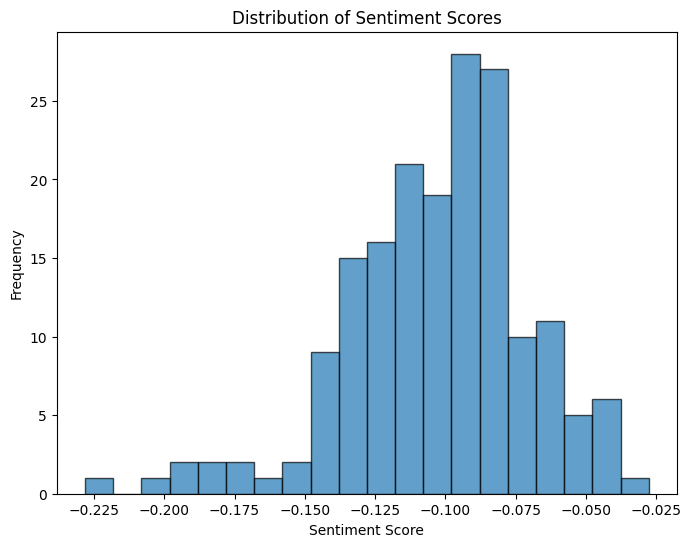

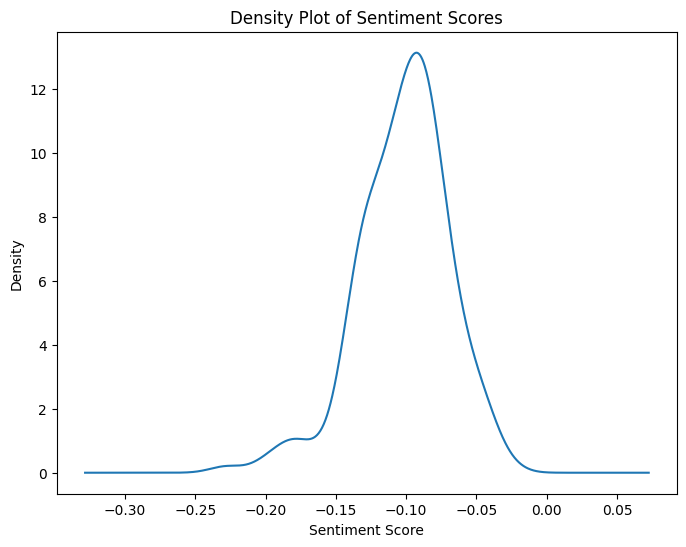

In [5]:
import matplotlib.pyplot as plt

# Analyze sentiment scores
sentiment_scores = df['sentiment_score']

# Create a histogram of sentiment scores
plt.figure(figsize=(8, 6))
plt.hist(sentiment_scores, bins=20, edgecolor='black', alpha=0.7)
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.title('Distribution of Sentiment Scores')
plt.show()

# Create a density plot of sentiment scores
plt.figure(figsize=(8, 6))
sentiment_scores.plot.kde()
plt.xlabel('Sentiment Score')
plt.ylabel('Density')
plt.title('Density Plot of Sentiment Scores')
plt.show()